In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gaussian_kde
import os
import yaml
import h5py
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import time

import warnings

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
sys.path.append(r'../tools_F-J/toollib_DisbaCode')
from objective_function import (ObjectiveFunctionDerivativeUsed, Forward)
from toollib_DisbaCode import forward
from toollib_DisbaCode import objective_function
from toollib_DisbaCode import empirical_relation
from toollib_DisbaCode import plot_disp
from toollib_DisbaCode import plot_model
from toollib_DisbaCode import plot_lcurve
from toollib_DisbaCode import plot_inversion    
from toollib_DisbaCode import plot_kernel

#from toollib_standard import maplib
#from toollib_standard import mathlib
#from toollib_standard import filelib
#from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    with open('a-project.yml', 'r', encoding='utf-8') as f:
        proj = yaml.load(f.read(), Loader=yaml.FullLoader)
    name_project = proj['name']
    #name_project = 'project/output_FJSJ_16-01/'               # Harmon server
elif flag_project == 1:
    with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
        proj = yaml.load(f.read(), Loader=yaml.FullLoader)
    name_project = proj['name']
    #name_project = 'project_repartrition/output_repar_01-03/'               # Harmon server


In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.2_01-01/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary


In [7]:
dir_ds = dir_project + info_basic['dir_ds']
dir_partition = dir_project + info_basic['dir_partition']
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet'] 
d_len = info_basic['d_len']
f = info_basic_bi['f']
c = np.linspace(info_basic['c_min'], info_basic['c_max'], info_basic['c_num'])

In [8]:
key_subworks = info_basic['key_subworks']
key_subworks = ['5--12-03']
#key_subworks = ['13--20-03','22--29-03','28--35-03','41--49-03']
#key_subworks = ['41--49-03']
#key_subworks = [str(i) for i in range(1,19)]
key_subworks

['5--12-03']

In [9]:
file_config = 'config_inv_fund.yml'
#file_config = 'config_inv.yml'
flag_forward = 1

In [10]:
if file_config == 'config_inv.yml':
    #info_basic['dir_image_inv'] = info_basic['dir_inv_dispernet'] + 'image_inv_' + info_basic['tag'] + '/'
    info_basic['dir_invfile'] = info_basic['dir_inv_dispernet'] + 'inversion/'
    info_basic['dir_disp_model'] = info_basic['dir_inv_dispernet'] + 'disp_model/'
    info_basic['dir_model'] = info_basic['dir_inv_dispernet'] + 'model/'
    dir_image = dir_project + info_basic['dir_image'] + 'inversion/'
    dir_invfile = dir_project + info_basic['dir_invfile']
    dir_disp_model = dir_project + info_basic['dir_disp_model']
    dir_model = dir_project + info_basic['dir_model']
    
else:
    #info_basic['dir_image_inv_fund'] = info_basic['dir_inv_dispernet'] + 'image_inv_fund_' + info_basic['tag'] + '/'
    info_basic['dir_invfile_fund'] = info_basic['dir_inv_dispernet'] + 'inversion_fund/'
    info_basic['dir_disp_model_fund'] = info_basic['dir_inv_dispernet'] + 'disp_model_fund/'
    info_basic['dir_model_fund'] = info_basic['dir_inv_dispernet'] + 'model_fund/'
    dir_image = dir_project + info_basic['dir_image'] + 'inversion_fund/'
    dir_invfile = dir_project + info_basic['dir_invfile_fund']
    dir_disp_model = dir_project + info_basic['dir_disp_model_fund']
    dir_model = dir_project + info_basic['dir_model_fund']
if not os.path.exists(dir_image):
    os.mkdir(dir_image)
if not os.path.exists(dir_invfile):
    os.mkdir(dir_invfile)
if not os.path.exists(dir_disp_model):
    os.mkdir(dir_disp_model)
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

### Forard and plot estimated disp and Vs

In [11]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [13]:
stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [14]:
dir_this = os.getcwd()
dir_this

'/home/harmon/data/git_repo/SGB_tomography_project'

5--12-03


elapsed time:     0.433
finish 1/1


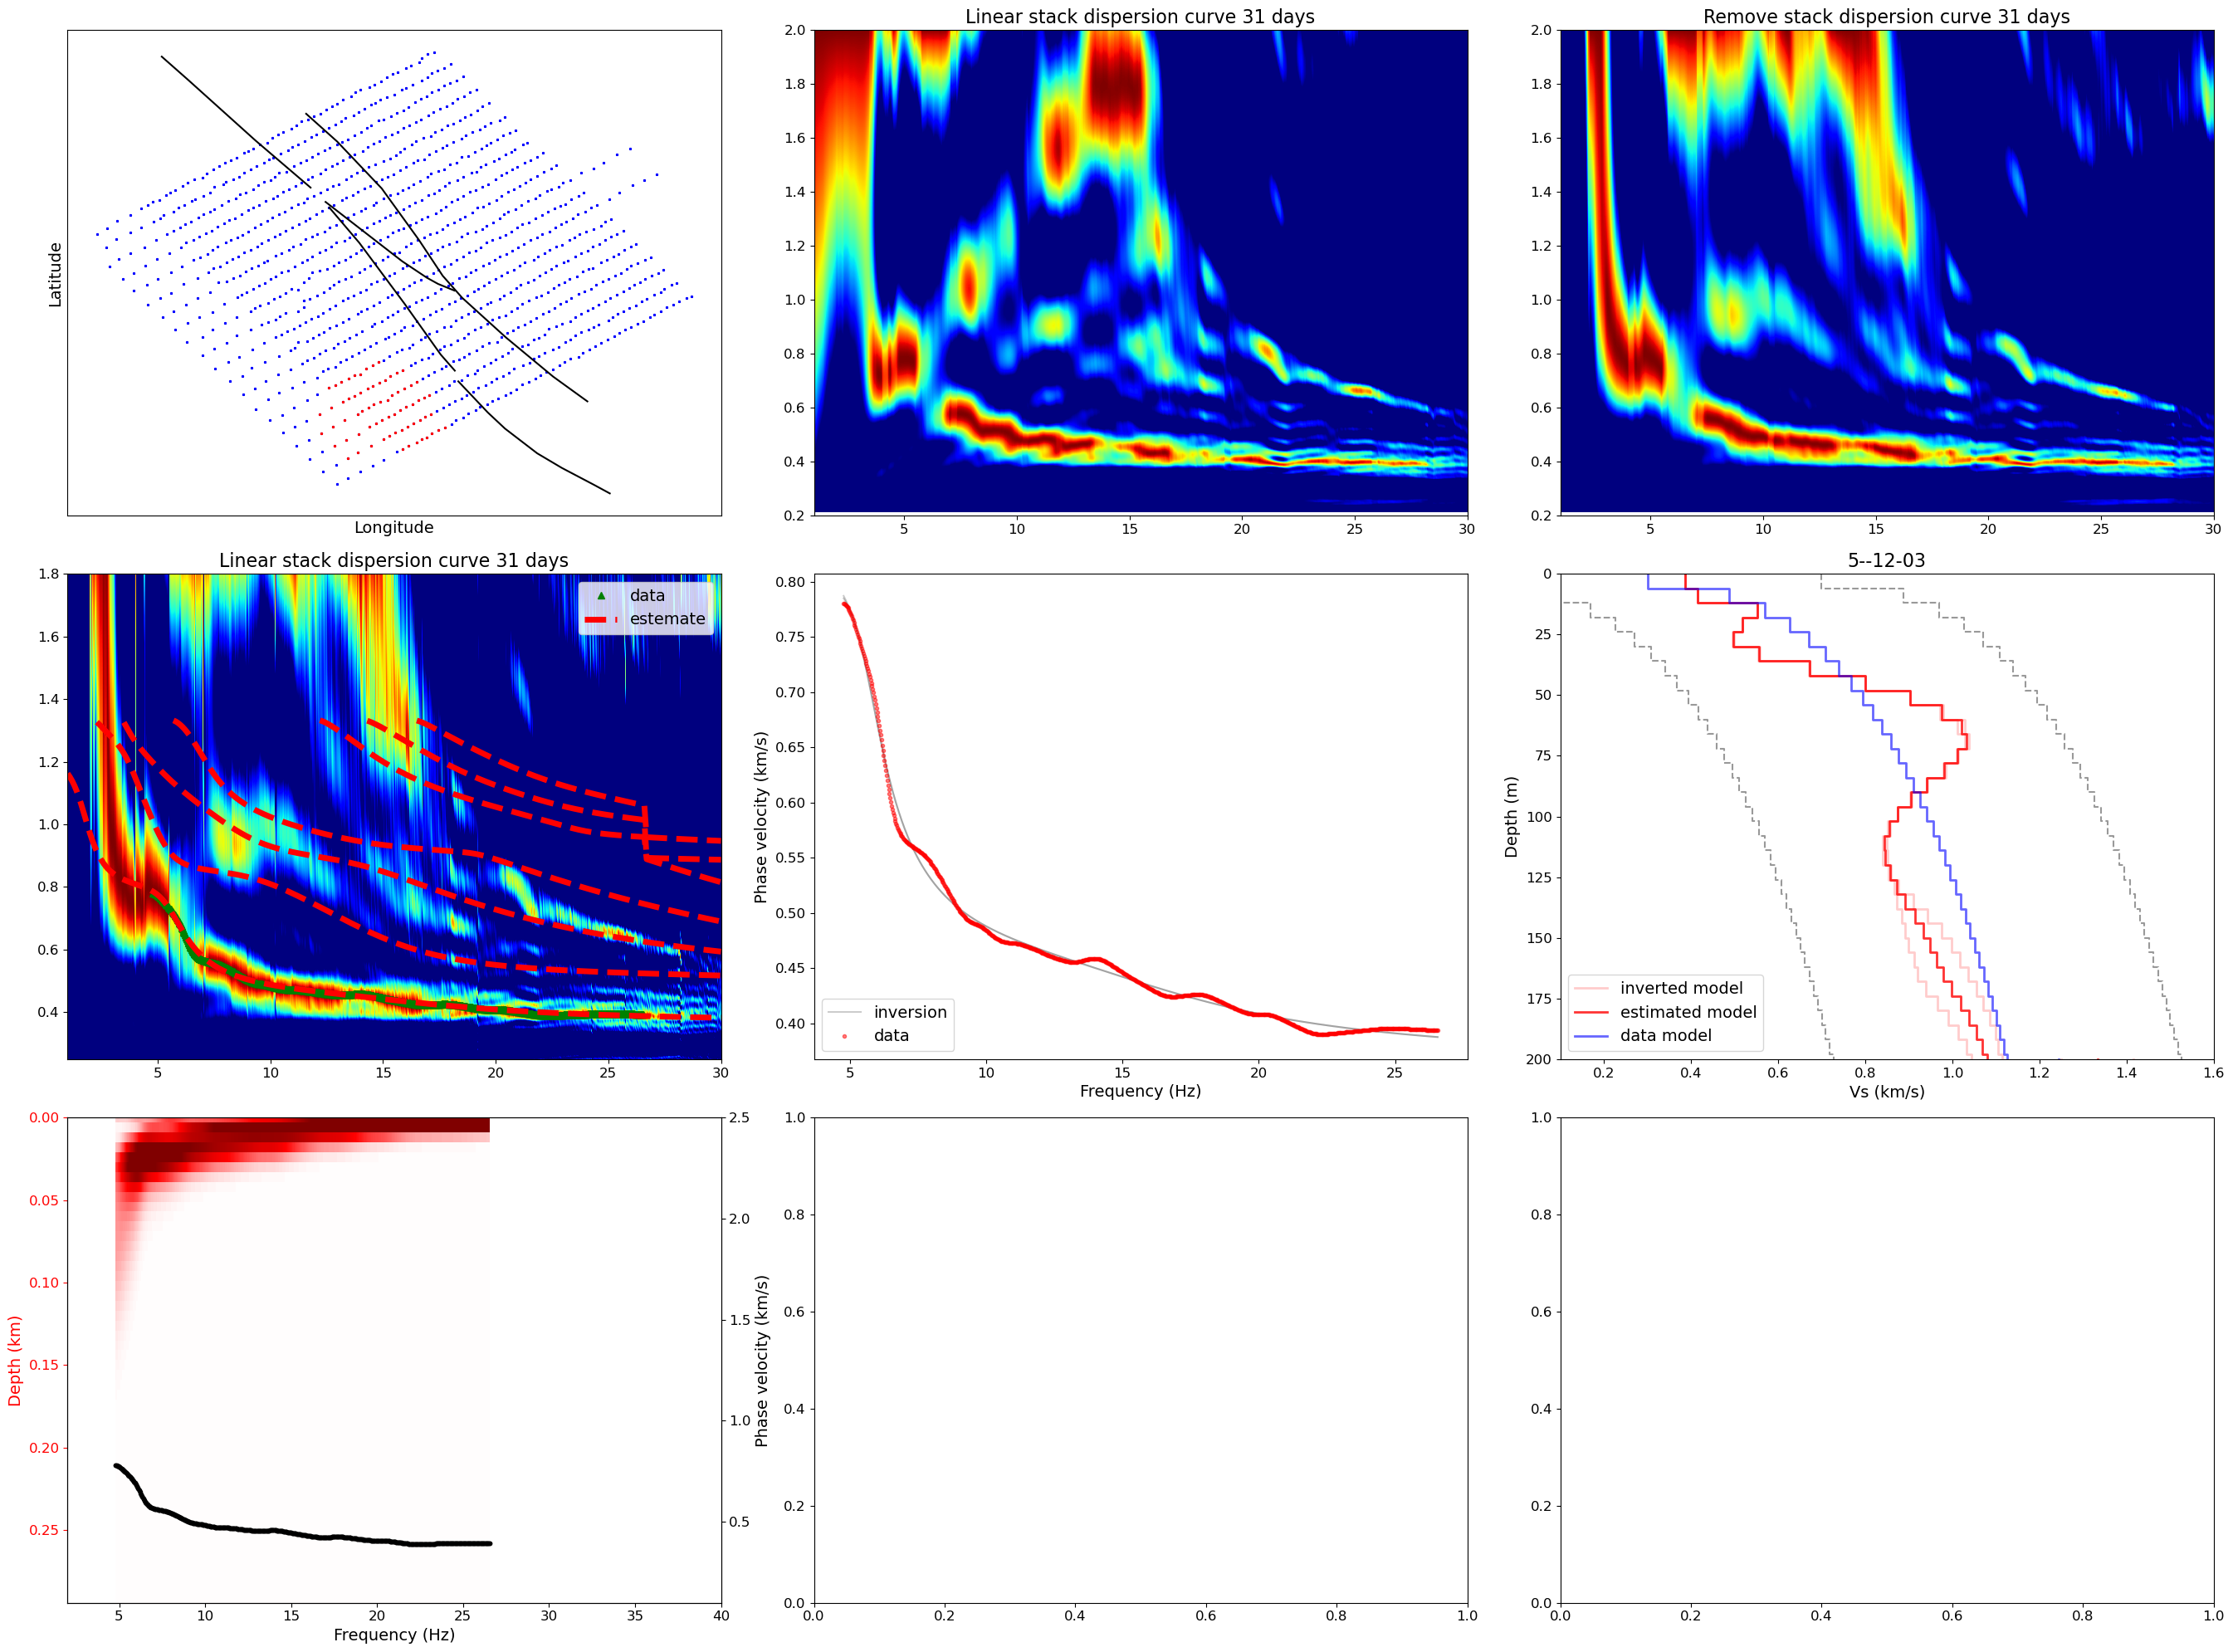

In [15]:
#key_subworks = ['25-06']
c_map = 'jet'
v_max = None
v_min = 0.1

#s.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/'+dir_project+'inv_dispernet')

with open(dir_project + info_basic['dir_inv_dispernet']+file_config, 'r') as fp:
    config = yaml.safe_load(fp)

all_disp = 0
show_init = 0
xlim_f = [1,30]
ylim_c = [0.25,1.8]
clim = [0,1]

flag_num = 0

dir_this = os.getcwd()

for key_subwork in key_subworks:
    key_subwork = str(key_subwork)
    print(key_subwork)
    fig,ax = plt.subplots(3,3,figsize=(27,20))

    data_file = 'data/ds_'+key_subwork+'curve.txt'
    file_model = 'model_'+key_subwork+'.txt'

    if os.path.exists(dir_invfile+file_model):
        os.remove(dir_invfile+file_model)

    file_inv =  'ds_'+key_subwork+'curve/'
    if not os.path.exists(dir_invfile+file_inv):
        print(key_subwork+'data file not exist')
        plt.close()
        continue


    os.chdir(dir_project_workspace +'/'+name_project+'/inv_dispernet/')
    disp_data = np.loadtxt(data_file)
    data_name = 'ds_'+key_subwork+'curve'
    ax[1][1] = plot_inversion.plot_disp(config, data_name, all_disp,ax[1][1])
    # s wave velocity inversion
    
    file_init = config['model_init']+key_subwork+'.txt'
    ax[1][2],model,fmt = plot_inversion.plot_model(config, data_name, show_init, file_model,file_init,ax[1][2])
    os.chdir(dir_this + '/')

    np.savetxt(dir_model+file_model, model, fmt=fmt)


    # forward
    filename = dir_disp_model +  'disp_model_'+key_subwork+'.txt'
    if flag_forward == 1:
        
        max_mode = 6
        
        forward.forward_cal(info_basic,max_mode,dir_model+file_model,filename)


    disp_model = np.loadtxt(filename)


    #os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    title0 = "Linear stack dispersion curve "+str(d_len)+' days'
    ax[1][0].set_xlim(xlim_f)
    ax[1][0].set_ylim(ylim_c)
    #ax[0] = plot_fj(ax[0],ds_remove,title0,f,c,xlim_f,0,clim)
    ax[1][0] = plotlib.plot_fj(ax[1][0],ds_remove,title0,f,c,0,v_min = v_min,v_max=v_max,c_map=c_map)
    
    

    
    modes = set(disp_data[:, 2].astype(int))
    for m in modes:
        d = disp_data[disp_data[:, 2] == m]
        if m==0:
            ax[1][0].plot(d[:, 0], d[:, 1], 'g^',label='data')
        else:
            ax[1][0].plot(d[:, 0], d[:, 1], 'g^')

    modes = set(disp_model[:, 2].astype(int))
    for m in modes:
        d = disp_model[disp_model[:, 2] == m]
        if m==0:
            ax[1][0].plot(d[:, 0], d[:, 1], 'r--',label='estemate',linewidth=5)
        else:
            ax[1][0].plot(d[:, 0], d[:, 1], 'r--',linewidth=5)
    ax[1][0].legend()
    ax[1][2].set_title(key_subwork)


    #plt.tight_layout()
    #plt.savefig(dir_image+'inversion_'+key_subwork+'.png',dpi=60)
    #plt.close()
    flag_num += 1
    

    #os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
    fmin = 2
    fmax = 40
    cmin = 0.1
    cmax = 2.5
    vmax = 0.3
    
    file_disp = dir_project + info_basic['dir_inv_dispernet']+'data/ds_'+key_subwork+'curve.txt'
    file_model = dir_model+'model_'+key_subwork+'.txt'
    disp = np.loadtxt(file_disp)
    m = int(max(set(disp[:,2])))
    
    #fig,ax = plt.subplots(1,m+1,figsize=(7*(m+1),6))
    if m > 2:
        m = 2
    for mode in range(m+1):
        #print(mode)
        #ax[2][mode] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,mode,vmax,ax[2][mode])
        
        try:
            ax[2][mode] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,mode,vmax,ax[2][mode])
        except:
            print('error')
    
    #ax[0][1] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,1,vmax,ax[0][1])
    #ax[1][0] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,2,vmax,ax[1][0])
    #ax[1][1] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,3,vmax,ax[1][1])


    xlim_T = [-1,1]
    #start = info_basic_bi['start'][key_subwork]
    #interval = info_basic_bi['interval'][key_subwork]
    #flag_time = info_basic_bi['flag_time'][key_subwork]
    # plot area
    #stalistname = dir_project+info_basic['stalistname']
    #stainfo = pd.read_excel(stalistname+'.xlsx',key_subwork)
    stalist = stations[key_subwork]
    lat_this = lat[key_subwork]
    lon_this = lon[key_subwork]
    nsta = len(stalist)
    
    ax[0][0]=plotlib.plot_area(ax[0][0],lon_all,lat_all,lon_this,lat_this)
    for i in range(len(faults)):
        ax[0][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
    


    # plot ncfs and ncfstW
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_linear = ds['ds_linear'][0]
    ds_remove = ds['ds_remove'][0]
    ds_linear = plotlib.smooth_ds(ds_linear)
    ds_remove = plotlib.smooth_ds(ds_remove)
    title0 = "Linear stack dispersion curve "+str(d_len)+' days'
    ax[0][1] = plotlib.plot_fj(ax[0][1],ds_linear,title0,f,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[0][1].set_xlim(xlim_f)

    title0 = "Remove stack dispersion curve "+str(d_len)+' days'
    ax[0][2] = plotlib.plot_fj(ax[0][2],ds_remove,title0,f,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[0][2].set_xlim(xlim_f)



    plt.tight_layout()
    #plt.savefig(dir_image+'Sens-kernel_'+key_subwork+'.png',dpi=60)
    plt.savefig(dir_image+'invplot_all_'+key_subwork+'.png',dpi=60)
    

    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))
    #plt.close()

### Write into xlsx

In [16]:
"""
# disp model xlsx
os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
filename = 'disp_model.xlsx'

if not os.path.exists(info_basic['dir_inv_dispernet']+filename):
    df = pd.DataFrame()
    df.to_excel(info_basic['dir_inv_dispernet']+filename,index=False)

books = load_workbook(info_basic['dir_inv_dispernet']+filename)
writers = pd.ExcelWriter(info_basic['dir_inv_dispernet']+filename, engine='openpyxl')
writers.book = books

flag_num = 0
for key_subwork in key_subworks:
    file_model = dir_inv_dispernet + 'disp_model_'+key_subwork+'.txt'
    disp_model = np.loadtxt(file_model)
    
    
    df = pd.DataFrame()
    df['f'] = disp_model[:, 0]
    df['c'] = disp_model[:, 1]
    df['mode'] = disp_model[:, 2]

    df.to_excel(writers,key_subwork,index=False)

    flag_num += 1
    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))

writers.save()
"""

"\n# disp model xlsx\nos.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')\nfilename = 'disp_model.xlsx'\n\nif not os.path.exists(info_basic['dir_inv_dispernet']+filename):\n    df = pd.DataFrame()\n    df.to_excel(info_basic['dir_inv_dispernet']+filename,index=False)\n\nbooks = load_workbook(info_basic['dir_inv_dispernet']+filename)\nwriters = pd.ExcelWriter(info_basic['dir_inv_dispernet']+filename, engine='openpyxl')\nwriters.book = books\n\nflag_num = 0\nfor key_subwork in key_subworks:\n    file_model = dir_inv_dispernet + 'disp_model_'+key_subwork+'.txt'\n    disp_model = np.loadtxt(file_model)\n    \n    \n    df = pd.DataFrame()\n    df['f'] = disp_model[:, 0]\n    df['c'] = disp_model[:, 1]\n    df['mode'] = disp_model[:, 2]\n\n    df.to_excel(writers,key_subwork,index=False)\n\n    flag_num += 1\n    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))\n\nwriters.save()\n"

In [17]:
"""
# disp data xlsx
os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
filename = 'structure_model_fund.xlsx'

if not os.path.exists(dir_project + info_basic['dir_inv_dispernet']+filename):
    df = pd.DataFrame()
    df.to_excel(dir_project + info_basic['dir_inv_dispernet']+filename,index=False)

books = load_workbook(dir_project + info_basic['dir_inv_dispernet']+filename)
writers = pd.ExcelWriter(dir_project + info_basic['dir_inv_dispernet']+filename, engine='openpyxl')
writers.book = books

flag_num = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    
    
    df = pd.DataFrame()
    df['layer'] = model[:, 0]
    df['z'] = model[:, 1]
    df['rho'] = model[:, 2]
    df['vs'] = model[:, 3]
    df['vp'] = model[:, 4]
    #df['std'] = model[:, 5]
    df.to_excel(writers,key_subwork,index=False)

    flag_num += 1
    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))

writers.save()
"""

"\n# disp data xlsx\nos.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')\nfilename = 'structure_model_fund.xlsx'\n\nif not os.path.exists(dir_project + info_basic['dir_inv_dispernet']+filename):\n    df = pd.DataFrame()\n    df.to_excel(dir_project + info_basic['dir_inv_dispernet']+filename,index=False)\n\nbooks = load_workbook(dir_project + info_basic['dir_inv_dispernet']+filename)\nwriters = pd.ExcelWriter(dir_project + info_basic['dir_inv_dispernet']+filename, engine='openpyxl')\nwriters.book = books\n\nflag_num = 0\nfor key_subwork in key_subworks:\n    file_model = dir_model + 'model_'+key_subwork+'.txt'\n    model = np.loadtxt(file_model)\n    \n    \n    df = pd.DataFrame()\n    df['layer'] = model[:, 0]\n    df['z'] = model[:, 1]\n    df['rho'] = model[:, 2]\n    df['vs'] = model[:, 3]\n    df['vp'] = model[:, 4]\n    #df['std'] = model[:, 5]\n    df.to_excel(writers,key_subwork,index=False)\n\n    flag_num += 1\n    print('finish '+str(flag_num)+'/'+str(len(key_su

In [18]:
"""
# disp data xlsx
os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
filename = 'disp_data.xlsx'

if not os.path.exists(info_basic['dir_inv_dispernet']+filename):
    df = pd.DataFrame()
    df.to_excel(info_basic['dir_inv_dispernet']+filename,index=False)

books = load_workbook(info_basic['dir_inv_dispernet']+filename)
writers = pd.ExcelWriter(info_basic['dir_inv_dispernet']+filename, engine='openpyxl')
writers.book = books

flag_num = 0
for key_subwork in key_subworks:
    file_model = dir_inv_dispernet + '/data/ds_'+key_subwork+'curve.txt'
    disp_model = np.loadtxt(file_model)
    
    
    df = pd.DataFrame()
    df['f'] = disp_model[:, 0]
    df['c'] = disp_model[:, 1]
    df['mode'] = disp_model[:, 2]

    df.to_excel(writers,key_subwork,index=False)

    flag_num += 1
    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))

writers.save()
"""

"\n# disp data xlsx\nos.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')\nfilename = 'disp_data.xlsx'\n\nif not os.path.exists(info_basic['dir_inv_dispernet']+filename):\n    df = pd.DataFrame()\n    df.to_excel(info_basic['dir_inv_dispernet']+filename,index=False)\n\nbooks = load_workbook(info_basic['dir_inv_dispernet']+filename)\nwriters = pd.ExcelWriter(info_basic['dir_inv_dispernet']+filename, engine='openpyxl')\nwriters.book = books\n\nflag_num = 0\nfor key_subwork in key_subworks:\n    file_model = dir_inv_dispernet + '/data/ds_'+key_subwork+'curve.txt'\n    disp_model = np.loadtxt(file_model)\n    \n    \n    df = pd.DataFrame()\n    df['f'] = disp_model[:, 0]\n    df['c'] = disp_model[:, 1]\n    df['mode'] = disp_model[:, 2]\n\n    df.to_excel(writers,key_subwork,index=False)\n\n    flag_num += 1\n    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))\n\nwriters.save()\n"

In [19]:
"""
dir_inv_dispernet = info_basic['dir_inv_dispernet']
os.listdir(dir_inv_dispernet)[0][-3:]
for file in os.listdir(dir_inv_dispernet):
    if file[-3:] == 'txt':
        os.remove(dir_inv_dispernet+file)
"""

"\ndir_inv_dispernet = info_basic['dir_inv_dispernet']\nos.listdir(dir_inv_dispernet)[0][-3:]\nfor file in os.listdir(dir_inv_dispernet):\n    if file[-3:] == 'txt':\n        os.remove(dir_inv_dispernet+file)\n"

In [20]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)